# Karim Kuserbaev

## Funcs

In [5]:
def get_df_low(code: int):
    train_df = pd.read_parquet(f"/kaggle/input/alfa-hack-dataset/train_data_lm_{code}.pqt")
    test_df = pd.read_parquet(f"/kaggle/input/alfa-hack-dataset/test_data_lm_{code}.pqt")

    cat_cols = [
        "channel_code", "city", "city_type",
        "okved", "segment", "start_cluster",
        "index_city_code", "ogrn_month", "ogrn_year",
    ]

    train_df[cat_cols] = train_df[cat_cols].astype("category")
    test_df[cat_cols] = test_df[cat_cols].astype("category")

    df = pd.concat([train_df, test_df], ignore_index=True)
    return df



def get_feature_description():
  feature_description = pd.read_excel("../data/feature_description.xlsx") # import feature_description to merge description
  feature_description.columns =  ['col_name', 'description', 'type']
  return feature_description



def cat_column_summary(df):
    """Для категорий всех столбцов"""
    df = df.select_dtypes(exclude="number")
    summary_data = []

    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })


    summary_df = pd.DataFrame(summary_data)
    summary_df_with_fd = pd.merge(summary_df, feature_description, on='col_name', suffixes=('_left', '_right'), how='left')

    return summary_df_with_fd

def num_column_summary(df):
    """Для численных всех столбцов"""

    df = df.select_dtypes(include="number")
    summary_data = []

    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()
        mean = df[col_name].mean()
        std = df[col_name].std()
        min_val = df[col_name].min()
        q25 = df[col_name].quantile(0.25)
        q50 = df[col_name].quantile(0.50)
        q75 = df[col_name].quantile(0.75)
        max_val = df[col_name].max()


        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'mean': mean,
            'std': std,
            'min': min_val,
            'q25': q25,
            'q50': q50,
            'q75': q75,
            'max': max_val,
            'distinct_values_counts': distinct_values_counts

        })




    summary_df = pd.DataFrame(summary_data)
    summary_df_with_fd = pd.merge(summary_df, feature_description, on='col_name', suffixes=('_left', '_right'), how='left')

    return summary_df_with_fd
# Пустые значения


def get_nan_3_month_df(df):

  nan_3_month_df = pd.DataFrame(df['id'].unique(), columns=['id'])

  for column in df.columns[1:]:
    start_time = time.time()
    result = df.groupby('id')[column].apply(
        lambda x: x.isna().all()).reset_index()
    nan_3_month_df = pd.merge(
        nan_3_month_df, result, on='id', suffixes=('_left', '_right'), how='left')
    end_time = time.time()
  return nan_3_month_df



def process_nan(x):
    try:
        x = x.dropna(
        ).values[-1] if x.isna().any() and not x.isna().all() else np.nan
        return x
    except:
        print(x)
        return x




def get_nan_values_3_month_df(df):

  nan_3_month_df = pd.DataFrame(df['id'].unique(), columns=['id'])
  for column in df.columns[1:]:
    start_time = time.time()
    result = df.groupby('id')[column].apply(
        lambda x: process_nan(x)).reset_index()
    nan_3_month_df = pd.merge(
        nan_3_month_df, result, on='id', how='left')
    end_time = time.time()
    print(f"{column} {end_time - start_time}")
  return nan_3_month_df



def plt_null_df(df):

    plt.figure(figsize=(15, 8))

    plt.imshow(df, aspect="auto", interpolation="nearest", cmap="viridis")

    plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')

    plt.xlabel("Column Number")
    plt.ylabel("Sample Number")

    plt.show()




# Корреляция
def plt_corr_df(df):

  corr_df = df.select_dtypes(include='number').corr().abs()

  plt.figure(figsize=(20, 15))
  dataplot = sns.heatmap(corr_df,
                        cmap="YlGnBu", annot=True, fmt=".1f",
                        annot_kws={'size': 5})
  plt.show()

def get_columns_corr(df, p: int):
    corr_df = df.select_dtypes(include='number').corr().abs()
    c1 = corr_df.unstack()

    c1_sorted = c1.sort_values(ascending=True)
    columns_above = {(col1, col2): c1_sorted[col1, col2] for col1, col2 in c1_sorted.index if c1_sorted[col1, col2] > p and col1 != col2}

    return dict(sorted(columns_above.items(), key=lambda item: item[1], reverse=True))

## Импорт библиотек и настройки

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
# !pip install catboost

In [2]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import os


from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool
import catboost
from catboost import *
from catboost import datasets


import numpy as np
import time
import json

import pandas as pd
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_rows', 93)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import warnings
from sklearn.utils import resample


# Отключить все предупреждения временно
warnings.filterwarnings("ignore")

# Включить предупреждения обратно
# warnings.filterwarnings("default")


import matplotlib.pyplot as plt

from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

import tensorflow as tf
from tensorflow import keras
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [156]:
!pip freeze | grep "numpy\|pandas\|lightgbm\|scikit-learn"

geopandas==0.14.3
lightgbm @ file:///tmp/lightgbm/lightgbm-4.2.0-py3-none-manylinux_2_31_x86_64.whl#sha256=26ed21477c12bb26edc4d6d51336cd43d5a8f7daf55ebbe27b0faf50ce96db23
numpy @ file:///home/conda/feedstock_root/build_artifacts/numpy_1707225380409/work/dist/numpy-1.26.4-cp310-cp310-linux_x86_64.whl#sha256=51131fd8fc130cd168aecaf1bc0ea85f92e8ffebf211772ceb16ac2e7f10d7ca
pandas==2.1.4
pandas-datareader==0.10.0
pandas-profiling==3.6.6
pandas-summary==0.2.0
pandasql==0.7.3
scikit-learn==1.4.2
scikit-learn-intelex==2024.2.0
sklearn-pandas==2.2.0


In [157]:
pd.options.display.max_rows = 93
pd.options.display.max_columns = 93

## Загрузка данных

In [158]:
df = pd.read_parquet("/kaggle/input/alfahack-test/df_restore_cal_avg_start_cluster_3.pqt")

df_org = pd.read_parquet("/kaggle/input/alfahack-test/df_restore_cat_avg.pqt")

In [159]:
df.isna().sum()

id                             0
avg_a_oper_1m_month_1     110901
avg_a_oper_1m_month_2     103513
avg_a_oper_1m_month_3      86857
avg_a_oper_3m_month_1      96121
                           ...  
sum_of_paym_2m_month_2     79825
sum_of_paym_2m_month_3     64956
sum_of_paym_6m_month_1     87444
sum_of_paym_6m_month_2     79825
sum_of_paym_6m_month_3     64956
Length: 250, dtype: int64

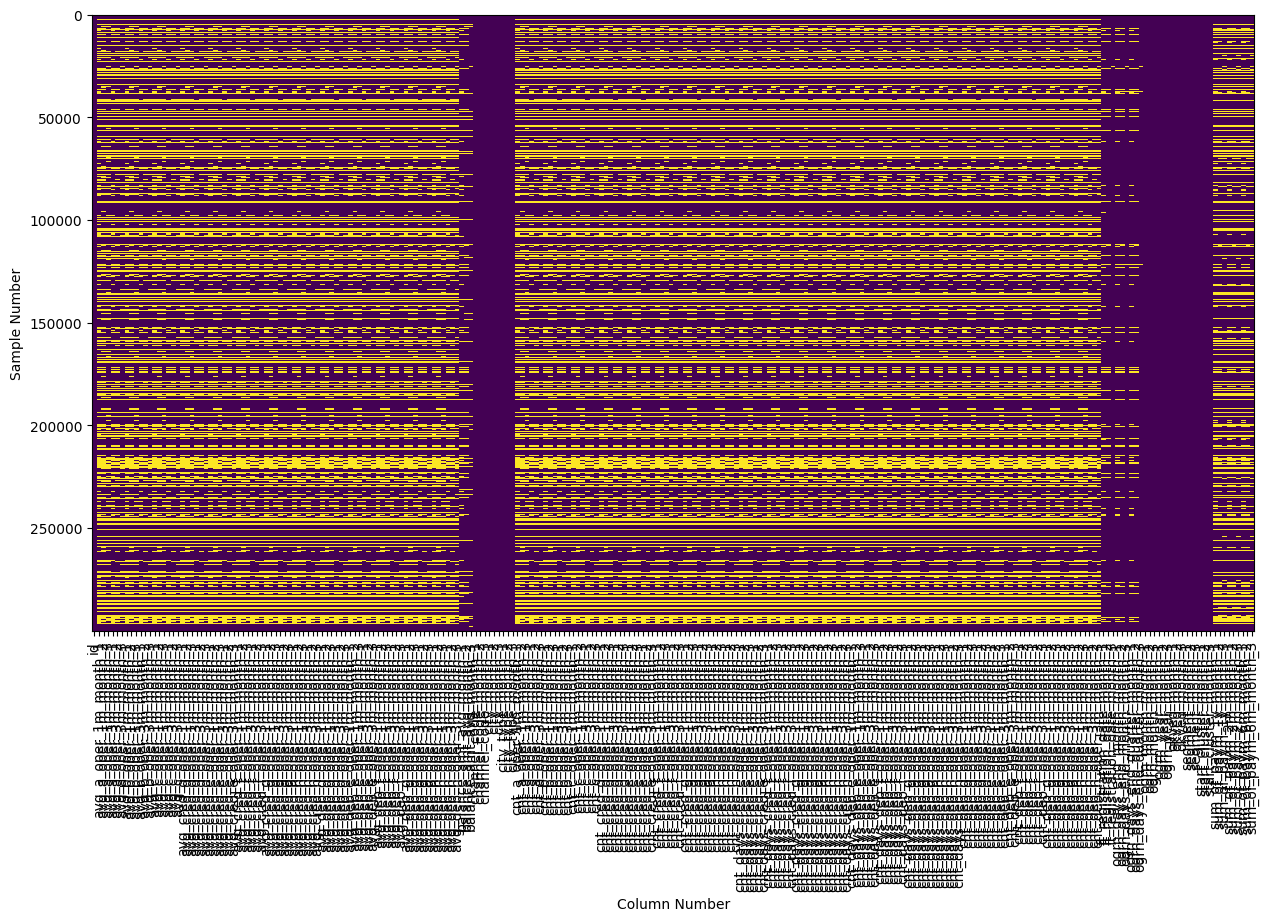

In [160]:
plt_null_df(df.isna())

## Анализ

In [161]:
train_df = df[df['id']< 200000]
test_df = df[df['id'] >= 200000]

Размерность

In [162]:
df.shape

(300000, 250)

In [163]:
train_df.shape, test_df.shape

((200000, 250), (100000, 250))

In [164]:
test_df[['id']]

,id
200000,200000
200001,200001
200002,200002
200003,200003
200004,200004
...,...
299995,299995
299996,299996
299997,299997
299998,299998


Количество строк без пропусков

In [165]:
train_df.dropna().shape

(114664, 250)

In [166]:
test_df.dropna().shape

(53150, 250)

## Предобработка

In [167]:
pivot_df = df_org.pivot_table(index='id', columns='date', aggfunc='first')

# Преобразуем мультииндексные столбцы в одноуровневые
pivot_df.columns = [f'{col[0]}_{col[1]}' for col in pivot_df.columns]

# Объединяем строки для каждого клиента в одну
pivot_df.reset_index(inplace=True)
pivot_df = pivot_df.drop(columns = ['end_cluster_month_1', 'end_cluster_month_2'] , axis = 0)

In [168]:
df['end_cluster_month_3'] = pivot_df['end_cluster_month_3'].copy()

In [169]:
df['end_cluster_month_3'] = df['end_cluster_month_3'].fillna('missing')

In [170]:
df['end_cluster_month_3']

0         {other}
1         {other}
2             {α}
3          {α, γ}
4             {α}
           ...   
299995    missing
299996    missing
299997    missing
299998    missing
299999    missing
Name: end_cluster_month_3, Length: 300000, dtype: object

In [109]:
# fill_values = {}

# # Заполнение числовых столбцов нулями
# for column in pivot_df.select_dtypes(include='number').columns:
#     fill_values[column] = 0

# # Заполнение строковых столбцов строкой "0"
# for column in pivot_df.select_dtypes(include='object').columns:
#     fill_values[column] = "0"

# # Применение заполнения к DataFrame
# pivot_df = pivot_df.fillna(value=fill_values)

In [110]:
# columns_to_drop = [
#     'city_type_month_1', 'ogrn_year_month_2', 'sum_a_oper_1m_month_1', 'sum_a_oper_1m_month_2',
#     'sum_a_oper_1m_month_3', 'sum_a_oper_3m_month_1', 'sum_a_oper_3m_month_2', 'sum_a_oper_3m_month_3',
#     'sum_b_oper_1m_month_1', 'sum_b_oper_1m_month_2', 'sum_b_oper_1m_month_3', 'sum_b_oper_3m_month_1',
#     'sum_b_oper_3m_month_2', 'sum_b_oper_3m_month_3', 'sum_c_oper_1m_month_1', 'sum_c_oper_1m_month_2',
#     'sum_c_oper_1m_month_3', 'sum_c_oper_3m_month_1', 'sum_c_oper_3m_month_2', 'sum_c_oper_3m_month_3',
#     'sum_cred_d_oper_1m_month_1', 'sum_cred_d_oper_1m_month_2', 'sum_cred_d_oper_1m_month_3',
#     'sum_cred_d_oper_3m_month_1', 'sum_cred_d_oper_3m_month_2', 'sum_cred_d_oper_3m_month_3',
#     'sum_cred_f_oper_1m_month_1', 'sum_cred_f_oper_1m_month_2', 'sum_cred_f_oper_1m_month_3',
#     'sum_cred_f_oper_3m_month_1', 'sum_cred_f_oper_3m_month_2', 'sum_cred_f_oper_3m_month_3',
#     'sum_cred_g_oper_1m_month_1', 'sum_cred_g_oper_1m_month_2', 'sum_cred_g_oper_1m_month_3'
# ]

# pivot_df.drop(columns=columns_to_drop, inplace=True, axis = 1)

In [171]:
train_df = df[df['id']< 200000]
test_df = df[df['id'] >= 200000]

In [175]:
test_df

,id,avg_a_oper_1m_month_1,avg_a_oper_1m_month_2,avg_a_oper_1m_month_3,avg_a_oper_3m_month_1,avg_a_oper_3m_month_2,avg_a_oper_3m_month_3,avg_b_oper_1m_month_1,avg_b_oper_1m_month_2,avg_b_oper_1m_month_3,avg_b_oper_3m_month_1,avg_b_oper_3m_month_2,avg_b_oper_3m_month_3,avg_c_oper_1m_month_1,avg_c_oper_1m_month_2,avg_c_oper_1m_month_3,avg_c_oper_3m_month_1,avg_c_oper_3m_month_2,avg_c_oper_3m_month_3,avg_cred_d_oper_1m_month_1,avg_cred_d_oper_1m_month_2,avg_cred_d_oper_1m_month_3,avg_cred_d_oper_3m_month_1,avg_cred_d_oper_3m_month_2,avg_cred_d_oper_3m_month_3,avg_cred_e_oper_1m_month_1,avg_cred_e_oper_1m_month_2,avg_cred_e_oper_1m_month_3,avg_cred_e_oper_3m_month_1,avg_cred_e_oper_3m_month_2,avg_cred_e_oper_3m_month_3,avg_cred_f_oper_1m_month_1,avg_cred_f_oper_1m_month_2,avg_cred_f_oper_1m_month_3,avg_cred_f_oper_3m_month_1,avg_cred_f_oper_3m_month_2,avg_cred_f_oper_3m_month_3,avg_cred_g_oper_1m_month_1,avg_cred_g_oper_1m_month_2,avg_cred_g_oper_1m_month_3,avg_cred_g_oper_3m_month_1,avg_cred_g_oper_3m_month_2,avg_cred_g_oper_3m_month_3,avg_cred_h_oper_1m_month_1,avg_cred_h_oper_1m_month_2,avg_cred_h_oper_1m_month_3,...,cnt_deb_g_oper_1m_month_1,cnt_deb_g_oper_1m_month_2,cnt_deb_g_oper_1m_month_3,cnt_deb_g_oper_3m_month_1,cnt_deb_g_oper_3m_month_2,cnt_deb_g_oper_3m_month_3,cnt_deb_h_oper_1m_month_1,cnt_deb_h_oper_1m_month_2,cnt_deb_h_oper_1m_month_3,cnt_deb_h_oper_3m_month_1,cnt_deb_h_oper_3m_month_2,cnt_deb_h_oper_3m_month_3,ft_registration_date_month_1,ft_registration_date_month_2,ft_registration_date_month_3,ogrn_days_end_month_month_1,ogrn_days_end_month_month_2,ogrn_days_end_month_month_3,ogrn_days_end_quarter_month_1,ogrn_days_end_quarter_month_2,ogrn_days_end_quarter_month_3,ogrn_month_month_1,ogrn_month_month_2,ogrn_month_month_3,ogrn_year_month_1,ogrn_year_month_2,ogrn_year_month_3,okved_month_1,okved_month_2,okved_month_3,segment_month_1,segment_month_2,segment_month_3,start_cluster_month_1,start_cluster_month_2,start_cluster_month_3,sum_of_paym_1y_month_1,sum_of_paym_1y_month_2,sum_of_paym_1y_month_3,sum_of_paym_2m_month_1,sum_of_paym_2m_month_2,sum_of_paym_2m_month_3,sum_of_paym_6m_month_1,sum_of_paym_6m_month_2,sum_of_paym_6m_month_3,end_cluster_month_3
200000,200000,1.2619,-0.1648,6.2595,4.4611,4.6360,5.4649,-0.0693,-0.0693,-0.0693,-0.0579,-0.0579,-0.0579,2.0327,8.9619,7.5097,1.7235,3.1367,4.3126,-0.2868,0.3991,-0.2868,-0.1783,-0.0261,-0.0477,0.3049,0.1510,0.1041,0.1660,0.2191,0.2144,-0.1166,-0.1166,-0.1166,-0.1032,-0.1032,-0.1032,0.3463,-0.1334,-0.1334,0.0116,0.0072,0.0072,0.6833,0.5932,0.3619,...,0.5152,0.5146,0.5152,0.4607,0.4596,0.4592,0.6525,0.6522,0.6519,0.5489,0.5495,0.5495,-0.6538,-0.6366,-0.6189,-1.5337,-1.5337,-1.5337,-1.6837,-1.6837,-1.6837,ogrn_month_8,ogrn_month_8,ogrn_month_8,ogrn_year_11,ogrn_year_11,ogrn_year_11,okved_0,okved_0,okved_0,segment_3,segment_3,segment_3,{α},{α},{α},0.6766,0.6884,0.6719,0.4168,0.4332,0.2240,0.3324,0.2843,0.2854,missing
200001,200001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.6630,-0.6458,-0.6281,0.0921,0.0921,0.0921,1.2200,1.2200,1.2200,ogrn_month_10,ogrn_month_10,ogrn_month_10,ogrn_year_11,ogrn_year_11,ogrn_year_11,okved_6,okved_6,okved_6,segment_3,segment_3,segment_3,{α},{α},{α},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,missing
200002,200002,9.3303,43.0412,24.7229,16.9913,45.0169,49.5095,-0.0693,-0.0693,-0.0693,-0.0579,-0.0579,-0.0579,2.8631,6.9606,3.0827,0.6740,2.2542,3.0010,-0.2868,-0.2868,-0.2868,-0.2751,-0.2751,-0.2751,1.3671,3.1970,1.3666,0.7800,1.9584,2.1341,-0.1166,-0.1166,-0.1166,-0.1032,-0.1032,-0.1032,3.0402,0.1662,0.1320,0.5372,0.5262,0.1301,2.3478,12.1308,4.6399,...,0.5172,0.5217,0.5223,0.4614,0.4630,0.4647,0.6587,0.6737,0.6587,0.5549,0.5639,0.5651,-0.7562,-0.7391,-0.7213,-1.0692,-1.0692,-1.0692,-1.5289,-1.5289,-1.5289,ogrn_month_6,ogrn_month_6,ogrn_month_6,ogrn_year_11,ogrn_yea

Обозначение категориальных признаков

In [176]:
cat_names = [
    "channel_code", "city", "city_type", "ogrn_month", "ogrn_year",
    "okved", "segment", "start_cluster"
]



cat_names = list(pivot_df.select_dtypes(exclude='number').columns)


In [177]:
cat_names.remove("end_cluster_month_3")

In [178]:
cat_names

['channel_code_month_1',
 'channel_code_month_2',
 'channel_code_month_3',
 'channel_code_month_4',
 'channel_code_month_5',
 'channel_code_month_6',
 'city_month_1',
 'city_month_2',
 'city_month_3',
 'city_month_4',
 'city_month_5',
 'city_month_6',
 'city_type_month_1',
 'city_type_month_2',
 'city_type_month_3',
 'city_type_month_4',
 'city_type_month_5',
 'city_type_month_6',
 'ogrn_month_month_1',
 'ogrn_month_month_2',
 'ogrn_month_month_3',
 'ogrn_month_month_4',
 'ogrn_month_month_5',
 'ogrn_month_month_6',
 'ogrn_year_month_1',
 'ogrn_year_month_2',
 'ogrn_year_month_3',
 'ogrn_year_month_4',
 'ogrn_year_month_5',
 'ogrn_year_month_6',
 'okved_month_1',
 'okved_month_2',
 'okved_month_3',
 'okved_month_4',
 'okved_month_5',
 'okved_month_6',
 'segment_month_1',
 'segment_month_2',
 'segment_month_3',
 'segment_month_4',
 'segment_month_5',
 'segment_month_6',
 'start_cluster_month_1',
 'start_cluster_month_2',
 'start_cluster_month_3',
 'start_cluster_month_4',
 'start_cluste

In [116]:

# label_encoders = {}

# for col in cat_names:
#     print(col)
#     label_encoders[col] = LabelEncoder().fit(pivot_df[col])

#     train_df[col] = label_encoders[col].transform(train_df[col])
#     test_df[col] = label_encoders[col].transform(test_df[col])

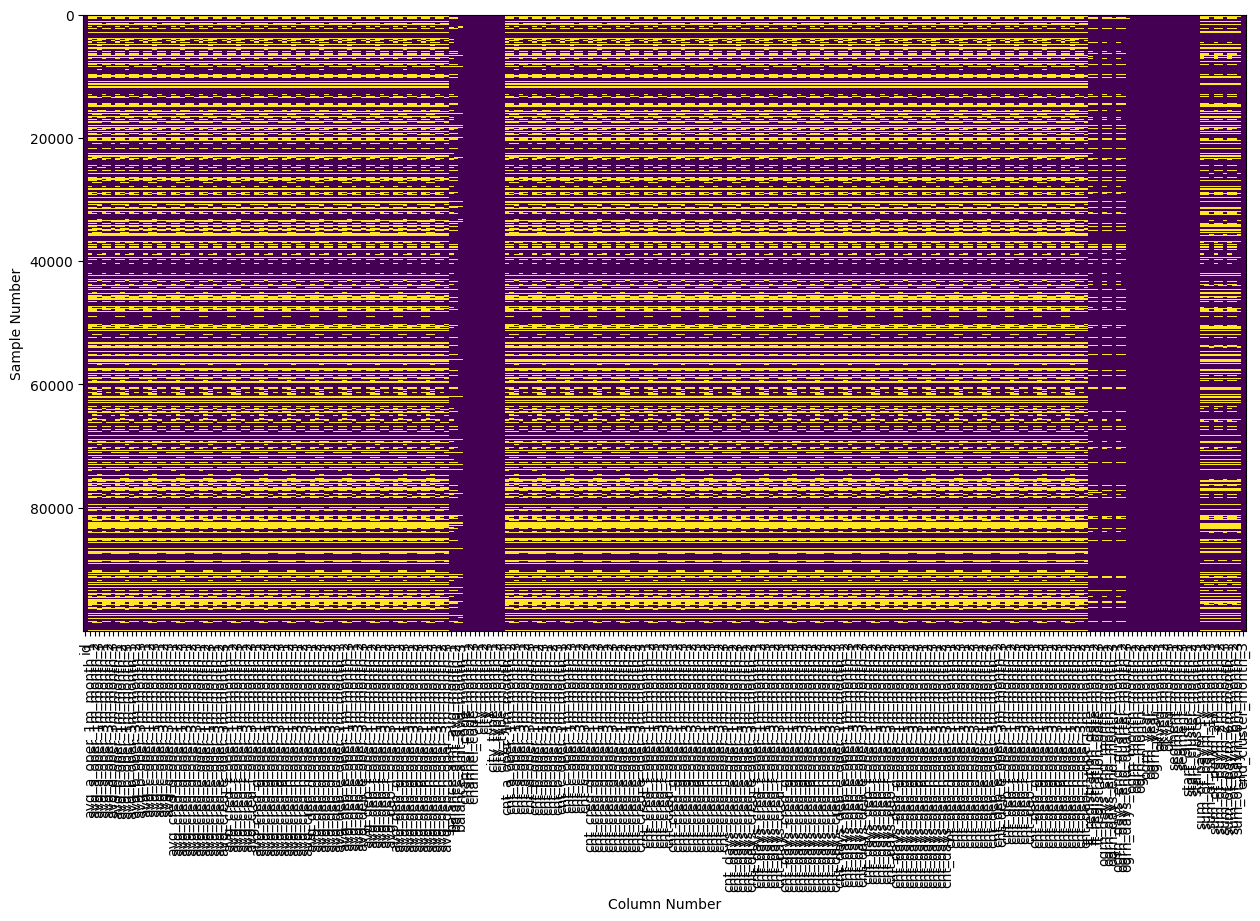

In [216]:
plt_null_df(test_df.isna())

### Создаем каждого клиента со всеми его признаками

### Создаем выборки для валидации и обучения

Деление на обучающую и тестовую, исправляем дизбаланс классов, если не требуется, пропустить эти блоки до следующего текста

In [179]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 0 to 199999
Columns: 251 entries, id to end_cluster_month_3
dtypes: float64(225), int64(1), object(25)
memory usage: 384.5+ MB


In [180]:
X = train_df.drop(["id"], axis=1) # оставляю end_cluster чтобы получить пропорцию классов, а потом ниже удалю в коде
y = train_df["end_cluster_month_3"]

x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42, shuffle=True)

In [120]:
# X = train_df.drop(["id"], axis=1) # оставляю end_cluster чтобы получить пропорцию классов, а потом ниже удалю в коде
# y = train_df["end_cluster_month_3"]



In [181]:
x_train['end_cluster_month_3'].value_counts().median()

1432.0

In [84]:
# Определение желаемого количества экземпляров каждого класса
desired_class_count = 1000  # Укажите ваше желаемое количество экземпляров

# Обработка дисбаланса классов
balanced_data = pd.DataFrame()
for cluster in x_train['end_cluster_month_3'].unique():
    cluster_data = x_train[x_train['end_cluster_month_3'] == cluster]
    if len(cluster_data) < desired_class_count:
        resampled_data = resample(
            cluster_data, replace=True, n_samples=desired_class_count, random_state=42)
    else:
        resampled_data = cluster_data.sample(
            n=desired_class_count, replace=False, random_state=42)
    balanced_data = pd.concat([balanced_data, resampled_data])

In [85]:
balanced_data['end_cluster_month_3'].value_counts()

end_cluster_month_3
{α}          1000
{}           1000
{α, η}       1000
{α, β}       1000
{other}      1000
{α, γ}       1000
{α, θ}       1000
{α, δ}       1000
{α, μ}       1000
{α, ε}       1000
{α, ε, θ}    1000
{α, ε, η}    1000
{α, ψ}       1000
{α, ε, ψ}    1000
{λ}          1000
{α, λ}       1000
{α, π}       1000
Name: count, dtype: int64

In [86]:
x_train = balanced_data

In [42]:
# Calculate current class proportions
class_proportions = x_train['end_cluster_month_3'].value_counts(normalize=True)

# Identify underrepresented classes
underrepresented_classes = class_proportions[class_proportions < 0.08].index

# Create an empty list to store additional rows
additional_rows = []

# Calculate the number of additional rows needed for each underrepresented class
for class_label in underrepresented_classes:
    current_proportion = class_proportions[class_label]
    desired_proportion = 0.08
    current_count = (x_train['end_cluster_month_3'] == class_label).sum()
    desired_count = int(desired_proportion * len(train_df))
    additional_count = desired_count - current_count

    if additional_count > 0:
        additional_samples = x_train[x_train['end_cluster_month_3'] == class_label].sample(n=additional_count, replace=True)
        additional_rows.append(additional_samples)

# Concatenate additional rows with the original dataframe
if additional_rows:
    x_train = pd.concat([x_train] + additional_rows, ignore_index=True)

# Verify the class proportions after balancing
print(x_train['end_cluster_month_3'].value_counts())


end_cluster_month_3
{α}          84479
{}           33282
{α, η}       16000
{α, β}       16000
{other}      16000
{α, γ}       16000
{α, θ}       16000
{α, δ}       16000
{α, μ}       16000
{α, ε}       16000
{α, ε, θ}    16000
{α, ε, η}    16000
{α, ψ}       16000
{α, ε, ψ}    16000
{λ}          16000
{α, λ}       16000
{α, π}       16000
Name: count, dtype: int64


In [182]:
y_train = x_train['end_cluster_month_3']
x_train = x_train.drop(['end_cluster_month_3'], axis=1)
x_val = x_val.drop(['end_cluster_month_3'], axis=1)

In [184]:
x_train['end_cluster_month_3']

In [185]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((160000, 249), (160000,), (40000, 249), (40000,))

In [186]:
y_train.value_counts()

end_cluster_month_3
{α}          84479
{}           33282
{other}      13280
{α, η}       10016
{α, γ}        9022
{α, β}        2934
{α, θ}        1785
{α, ε}        1476
{α, δ}        1432
{α, ψ}         664
{α, μ}         587
{α, ε, η}      400
{α, ε, θ}      297
{α, λ}         218
{α, ε, ψ}       79
{λ}             45
{α, π}           4
Name: count, dtype: int64

Деление на тестовую и обучающую выборку без дизбаланса

In [143]:
# X = train_df.drop(["id", "date", "end_cluster"], axis=1)
# y = train_df["end_cluster"]

# x_train, x_val, y_train, y_val = train_test_split(X, y,
#                                                   test_size=0.2,
#                                                   random_state=42)

## Обучение модели

Кросс-валидация для CatBoost (не нажимать если не разбираешься). Если не разбираешься, идти к следующему блоку текста

In [ ]:
from catboost import cv

params = {
    'loss_function': 'MultiClass',
    'iterations': 512,
    'random_seed': 43,
    'learning_rate': 0.1,
    'depth': 12,
    'task_type': 'GPU',
    'devices':'0'
}

cv_data = cv(
    params=params,
    pool=pool1,
    fold_count=5, # Разбивка выборки на 5 кусочков
    shuffle=True, # Перемешаем наши данные
    partition_random_seed=0,
    plot=True, # Никуда без визуализатора
    stratified=True,
    verbose=30
)

In [ ]:
cv_data

In [ ]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])
print("Best validation Logloss score, stratified: {:.4f}+/-{:.3f} on step {}".format(
best_value, cv_data['test-Logloss-std'][best_iter], best_iter))

## Начало обучения

### CatBoostClassifier

model #13, classes balanced

In [187]:
model = CatBoostClassifier(iterations=1024,
                           depth=7,
                           learning_rate=0.075,
                           random_seed=47,
                           loss_function='MultiClass',
                           task_type="GPU",
                           devices='0',
                           early_stopping_rounds=60
                          )


In [188]:
def train_catboost(model, x_train, y_train, x_val, y_val, cat_names):

    model.fit(
    x_train, y_train,
    cat_features=np.array(cat_names),
    eval_set=(x_val, y_val),
    verbose=15 # через сколько итераций выводить стату
    )
    model.save_model('catboost_model_no_end_claster.json') # сохранение модели
    feature_importance = model.get_feature_importance(prettified=True) # датасет с важностью признаков

    return feature_importance

In [189]:
cat_names = x_train.select_dtypes(exclude='number').columns

In [190]:
feature_importance = train_catboost(model, x_train, y_train, x_val, y_val, cat_names)

0:	learn: 2.2612641	test: 2.2109287	best: 2.2109287 (0)	total: 8.24s	remaining: 2h 20m 30s
15:	learn: 1.1378130	test: 1.0399615	best: 1.0399615 (15)	total: 9.05s	remaining: 9m 30s
30:	learn: 0.9644263	test: 0.8706466	best: 0.8706466 (30)	total: 9.89s	remaining: 5m 16s
45:	learn: 0.9101431	test: 0.8203487	best: 0.8203487 (45)	total: 10.7s	remaining: 3m 47s
60:	learn: 0.8868949	test: 0.8021856	best: 0.8021856 (60)	total: 11.5s	remaining: 3m 1s
75:	learn: 0.8729688	test: 0.7923337	best: 0.7923337 (75)	total: 12.3s	remaining: 2m 33s
90:	learn: 0.8622774	test: 0.7867296	best: 0.7867296 (90)	total: 13.1s	remaining: 2m 14s
105:	learn: 0.8547398	test: 0.7823606	best: 0.7823606 (105)	total: 13.9s	remaining: 2m
120:	learn: 0.8482028	test: 0.7790287	best: 0.7790287 (120)	total: 14.7s	remaining: 1m 49s
135:	learn: 0.8422467	test: 0.7761852	best: 0.7761852 (135)	total: 15.5s	remaining: 1m 41s
150:	learn: 0.8376954	test: 0.7744246	best: 0.7744246 (150)	total: 16.3s	remaining: 1m 34s
165:	learn: 0.83

In [191]:
feature_importance.head(30)

,Feature Id,Importances
0,start_cluster_month_2,8.5630
1,balance_amt_avg_month_3,4.4272
2,city_month_1,3.4982
3,start_cluster_month_1,3.4843
4,okved_month_3,2.9228
5,start_cluster_month_3,2.7824
6,ft_registration_date_month_3,2.7519
7,okved_month_1,2.4258
8,okved_month_2,2.1140
9,channel_code_month_2,1.9068


Модель LGBM, блоки кода не нажимать чтобы не сбросилась model CatBoost. Я еще не тестил эту модель, переходи к метрикам

### LGBM

В качестве базовой модели возьмем LGBM обучим на всех признаках

In [ ]:
model = LGBMClassifier(verbosity=-1, random_state=42, n_jobs=-1)
model.fit(x_train, y_train)

LGBMClassifier(n_jobs=-1, random_state=42, verbosity=-1)

### Ансамбль 2

In [296]:
%%time
base_models = [
    ('catboost', CatBoostClassifier(iterations=1024,
                                     depth=6,
                                     learning_rate=0.075,
                                     random_seed=43,
                                     loss_function='MultiClass',
                                     task_type="GPU",
                                     devices='0',
                                     early_stopping_rounds=20,
                                     verbose=500)),
    ('lgbm', LGBMClassifier(n_estimators=100, max_depth=3, verbosity=-1, random_state=42, n_jobs=-1, tree_method= 'gpu_hist')),
    ('xgboost', XGBClassifier(n_estimators=100, max_depth=3, verbosity=0, random_state=42, n_jobs=-1, tree_method= 'gpu_hist'))
]

meta_model = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=5)

model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=2)

model.fit(x_train, y_train)

### Метрики

Зададим функцию для взвешенной метрики roc auc

In [30]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [31]:
cluster_weights = pd.read_excel("/kaggle/input/alfa-hack-dataset/cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

Проверка работы модели

In [194]:
y_pred_proba = model.predict_proba(x_val)
y_pred_proba.shape

(40000, 17)

In [195]:
y_val

119737        {α}
72272     {other}
158154        {α}
65426     {other}
30074         {α}
           ...   
4174           {}
91537          {}
156449        {α}
184376     {α, η}
6584       {α, γ}
Name: end_cluster_month_3, Length: 40000, dtype: object

In [196]:
y_pred_proba[0]

array([3.74840936e-02, 2.66341659e-03, 3.57739528e-02, 5.36200370e-02,
       1.72263547e-02, 8.79676965e-05, 5.80103036e-04, 5.41346595e-05,
       2.24436122e-03, 6.88092636e-03, 1.30852748e-03, 3.19673046e-03,
       8.04054323e-04, 2.61144680e-05, 8.37446937e-04, 8.37182319e-01,
       2.94593955e-05])

In [197]:
weighted_roc_auc(y_val, y_pred_proba, model.classes_, weights_dict)

0.9137785559449234

## Прогноз на тестовой выборке

In [198]:
sample_submission_df = pd.read_csv("/kaggle/input/sample-submission/sample_submission.csv") # поменять на свой
last_m_test_df = test_df
last_m_test_df = last_m_test_df.drop(["id", 'end_cluster_month_3'], axis=1)

pool2 = Pool(data=last_m_test_df, cat_features=np.array(cat_names))

test_pred_proba = model.predict_proba(pool2) # last_m_test_df
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=model.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("catboost_submission_akm_14.csv", index=False) # сохранение модели

In [199]:
sample_submission_df.shape # если (100000, 18), то все правильно. Если нет - надо писать Кариму и спрашивать(

(100000, 18)

In [200]:
sample_submission_df

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.0142,0.0097,0.0277,0.0236,0.0047,0.0002,0.0019,0.0004,0.0069,0.0025,0.0211,0.0006,0.0032,0.0000,0.0025,0.8807,0.0000
1,200001,0.0066,0.5684,0.0006,0.0021,0.0009,0.0001,0.0006,0.0000,0.0013,0.0074,0.0017,0.0007,0.0007,0.0000,0.0016,0.4065,0.0007
2,200002,0.6264,0.0016,0.0033,0.0686,0.0126,0.0017,0.0029,0.0132,0.0254,0.0145,0.0160,0.0141,0.0061,0.0000,0.0878,0.1057,0.0000
3,200003,0.0386,0.5477,0.0005,0.0016,0.0004,0.0007,0.0003,0.0001,0.0008,0.0216,0.0024,0.0001,0.0008,0.0000,0.0006,0.3839,0.0000
4,200004,0.0994,0.0667,0.0135,0.0432,0.0083,0.0016,0.0027,0.0005,0.0122,0.0221,0.0063,0.0015,0.0256,0.0000,0.0023,0.6939,0.0003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,299995,0.0081,0.3704,0.0020,0.0035,0.0007,0.0000,0.0004,0.0000,0.0009,0.0006,0.0012,0.0002,0.0001,0.0000,0.0004,0.6113,0.0001
99996,299996,0.0249,0.0482,0.0109,0.0455,0.0072,0.0005,0.0003,0.0001,0.0090,0.0074,0.0089,0.0043,0.0027,0.0000,0.0030,0.8262,0.0009
99997,299997,0.0297,0.0321,0.0336,0.0594,0.0120,0.0001,0.0007,0.0007,0.0193,0.0040,0.0088,0.0011,0.0019,0.0000,0.0159,0.7808,0.0000
99998,299998,0.0755,0.1098,0.0138,0.0595,0.0066,0.0012,0.0040,0.0007,0.0152,0.0111,0.0121,0.0093,0.0091,0.0000,0.0068,0.6630,0.0023


# Neural Network

In [79]:
df_restore_start_cluster = pd.read_parquet('/kaggle/input/alfahack-test/df_0.902.pqt')

In [61]:
df_restore_start_cluster.shape

(300000, 336)

In [62]:
df_restore_start_cluster.head()

,id,avg_a_oper_1m_month_1,avg_a_oper_1m_month_2,avg_a_oper_1m_month_3,avg_a_oper_3m_month_1,avg_a_oper_3m_month_2,avg_a_oper_3m_month_3,avg_b_oper_1m_month_1,avg_b_oper_1m_month_2,avg_b_oper_1m_month_3,...,sum_deb_h_oper_3m_month_3,sum_of_paym_1y_month_1,sum_of_paym_1y_month_2,sum_of_paym_1y_month_3,sum_of_paym_2m_month_1,sum_of_paym_2m_month_2,sum_of_paym_2m_month_3,sum_of_paym_6m_month_1,sum_of_paym_6m_month_2,sum_of_paym_6m_month_3
0,0,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,0.8770,0.5115,0.4864,0.4805,0.9423,0.6457,0.4036,0.5360,0.5364,0.6132
1,1,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,0.0432,0.0520,0.0336,0.0395,0.0141,-0.0576,-0.0921,0.0438,0.0350,0.0252
2,2,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,-0.1656,-0.2919,-0.2907,-0.2883,-0.2558,-0.2679,-0.2559,-0.2871,-0.2850,-0.2807
3,3,NaN,-0.4528,NaN,-0.9934,-0.9934,-0.9934,NaN,-0.0693,NaN,...,-0.1656,-0.2428,-0.2629,-0.2733,-0.2740,-0.2740,-0.2740,-0.2688,-0.2944,-0.2944
4,4,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,-0.0783,-0.1246,-0.1219,-0.1289,-0.1038,-0.1342,-0.1667,-0.1300,-0.1340,-0.1428


In [63]:
for col in df_restore_start_cluster.select_dtypes('float64').columns:
    df_restore_start_cluster[col].fillna(df_restore_start_cluster[col].min()-0.0001,inplace=True)

In [64]:
df_restore_start_cluster.head()

,id,avg_a_oper_1m_month_1,avg_a_oper_1m_month_2,avg_a_oper_1m_month_3,avg_a_oper_3m_month_1,avg_a_oper_3m_month_2,avg_a_oper_3m_month_3,avg_b_oper_1m_month_1,avg_b_oper_1m_month_2,avg_b_oper_1m_month_3,...,sum_deb_h_oper_3m_month_3,sum_of_paym_1y_month_1,sum_of_paym_1y_month_2,sum_of_paym_1y_month_3,sum_of_paym_2m_month_1,sum_of_paym_2m_month_2,sum_of_paym_2m_month_3,sum_of_paym_6m_month_1,sum_of_paym_6m_month_2,sum_of_paym_6m_month_3
0,0,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,0.8770,0.5115,0.4864,0.4805,0.9423,0.6457,0.4036,0.5360,0.5364,0.6132
1,1,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,0.0432,0.0520,0.0336,0.0395,0.0141,-0.0576,-0.0921,0.0438,0.0350,0.0252
2,2,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,-0.1656,-0.2919,-0.2907,-0.2883,-0.2558,-0.2679,-0.2559,-0.2871,-0.2850,-0.2807
3,3,-0.4529,-0.4528,-0.4529,-0.9934,-0.9934,-0.9934,-0.0694,-0.0693,-0.0694,...,-0.1656,-0.2428,-0.2629,-0.2733,-0.2740,-0.2740,-0.2740,-0.2688,-0.2944,-0.2944
4,4,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,-0.0783,-0.1246,-0.1219,-0.1289,-0.1038,-0.1342,-0.1667,-0.1300,-0.1340,-0.1428


In [65]:
train_df = df_restore_start_cluster[df_restore_start_cluster['id']< 200000].copy()
test_df = df_restore_start_cluster[df_restore_start_cluster['id'] >= 200000].copy()

In [144]:
train_df[list(train_df.select_dtypes('category'))] = train_df[list(train_df.select_dtypes('category'))].astype('object')
test_df[list(test_df.select_dtypes('category'))] = test_df[list(test_df.select_dtypes('category'))].astype('object')

In [128]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Columns: 121 entries, id to giga_feature
dtypes: float64(102), int64(10), object(9)
memory usage: 553.9+ MB


In [129]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290120 entries, 0 to 290119
Columns: 120 entries, id to giga_feature
dtypes: float64(102), int64(10), object(8)
memory usage: 265.6+ MB


In [130]:
x_train, x_val = train_test_split(train_df.drop(['id', 'date'], axis=1), test_size=0.2, random_state=42, shuffle=True)

In [131]:
x_train.shape, x_val.shape

((480000, 119), (120000, 119))

In [68]:
df_restore_start_cluster.select_dtypes(include=['object']).isna().sum().sum()

0

In [69]:
df_restore_start_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Columns: 336 entries, id to sum_of_paym_6m_month_3
dtypes: float64(321), int64(1), object(14)
memory usage: 769.0+ MB


In [70]:
# import torch

# # Загрузка данных
# data = df_restore_start_cluster.copy()

# for col in data.select_dtypes('float64').columns:
#     data[col].fillna(data[col].min()-0.001,inplace=True)

# train_data = data[data['id']< 200000].copy()
# test_data = data[data['id'] >= 200000].copy()

# cat_columns = list(df_restore_start_cluster.select_dtypes('object'))
# for col in cat_columns:
#     label_encoder = LabelEncoder().fit(data[col])
#     train_data[col] = label_encoder.transform(train_data[col])
#     test_data[col] = label_encoder.transform(test_data[col])

# test_data.drop(['id','end_cluster_month_3'], axis=1, inplace=True)
    

    
# X = train_data.drop(['id', 'end_cluster_month_3'], axis=1)
# y = train_data['end_cluster_month_3']

# x_train, x_val, y_train, y_val = train_test_split(X, y,
#                                                   test_size=0.2,
#                                                   random_state=42)

# # # Преобразование данных в тензоры PyTorch
# # x_train = torch.tensor(x_train.values, dtype=torch.float32)
# # y_train = torch.tensor(y_train.values, dtype=torch.float32)

# # x_val = torch.tensor(x_val.values, dtype=torch.float32)
# # y_val = torch.tensor(y_val.values, dtype=torch.float32)

# # x_test = torch.tensor(test_data.values, dtype=torch.float32)

In [71]:
# x_test = test_data.copy()

In [72]:
# x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape

In [73]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device

In [74]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

# class MultiClassNN(nn.Module):
#     def __init__(self, input_size, num_classes):
#         super(MultiClassNN, self).__init__()
#         self.fc1 = nn.Linear(input_size, 256)
#         self.fc2 = nn.Linear(256, 128)
#         self.fc3 = nn.Linear(128, num_classes)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# # Определение модели и функции потерь
# input_size = x_train.shape[1]  # Размер входных данных
# num_classes = len(y_train.unique())  # Количество классов
# model = MultiClassNN(input_size, num_classes).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Преобразование данных в формат PyTorch DataLoader
# train_dataset = TensorDataset(torch.Tensor(x_train.values).to(device), torch.Tensor(y_train.values).to(device))
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# # Обучение модели
# num_epochs = 10
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for inputs, labels in train_loader:
#         # Обнуление градиентов
#         optimizer.zero_grad()

#         # Передача данных через модель
#         outputs = model(inputs)

#         # Вычисление функции потерь
#         loss = criterion(outputs, labels)

#         # Обратное распространение и оптимизация
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     # Вывод промежуточных результатов
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

# # Оценка модели на тестовом наборе данных
# with torch.no_grad():
#     outputs = model(torch.Tensor(x_val.values).to(device))
#     _, predicted = torch.max(outputs, 1)
#     correct = (predicted == torch.LongTensor(y_val.values).to(device)).sum().item()
#     accuracy = correct / len(y_val)
#     print(f'Test Accuracy: {accuracy:.4f}')


In [104]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 480000 entries, 501294 to 121958
Columns: 123 entries, balance_amt_avg to giga_feature
dtypes: float64(106), int64(9), object(8)
memory usage: 454.1+ MB


In [105]:
x_train.isna().sum().sum()

47250

In [132]:
from pytorch_tabular import TabularModel
from pytorch_tabular.models import GANDALFConfig, TabNetModelConfig, NodeConfig, CategoryEmbeddingModelConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig


num_col_names = list(train_df.select_dtypes('float64')) + list(train_df.select_dtypes('int64'))
num_col_names.remove('id')
cat_col_names = list(train_df.select_dtypes('object'))
cat_col_names.remove('end_cluster')
cat_col_names.remove('date')


data_config = DataConfig(
    target=[
        'end_cluster'
    ],  # target should always be a list. Multi-targets are only supported for regression. Multi-Task Classification is not implemented
    continuous_cols=num_col_names,
    categorical_cols=cat_col_names,
)
trainer_config = TrainerConfig(
    auto_lr_find=True,  # Runs the LRFinder to automatically derive a learning rate
    batch_size=2048,
    max_epochs=100,
    early_stopping_patience=5,
    load_best=True
)

optimizer_config = OptimizerConfig()
model_config = CategoryEmbeddingModelConfig(
    task="classification",
    layers="1024-512-256-128",  # Number of nodes in each layer
    activation="LeakyReLU"  # Activation between each layers
)


tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    verbose=True
)



In [133]:
tabular_model.fit(train=x_train, validation=x_val)

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │  957 K │
│ 1 │ _embedding_layer │ Embedding1dLayer          │  449 K │
│ 2 │ head             │ LinearHead                │  2.2 K │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │
└───┴──────────────────┴───────────────────────────┴────────┘

Trainable params: 1.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.4 M                                                                                                
Total estimated model params size (MB): 5

Output()

In [135]:
y_pred = tabular_model.predict(x_val.drop(['end_cluster'], axis=1))
y_val = x_val['end_cluster']
y_pred.drop(['prediction'], axis=1, inplace=True)
model_classes = ['{other}', '{}', '{α, β}', '{α, γ}', '{α, δ}', '{α, ε, η}', '{α, ε, θ}', '{α, ε, ψ}', '{α, ε}', '{α, η}', '{α, θ}', '{α, λ}', '{α, μ}', '{α, π}', '{α, ψ}', '{α}', '{λ}']
y_pred.columns = model_classes

In [136]:
weighted_roc_auc(y_val, y_pred, model_classes, weights_dict)

0.9882376745934938

In [ ]:
test_df.drop(['id'], axis=1, inplace=True)

In [145]:
pred_df = tabular_model.predict(test_df[test_df["date"] == "month_6"].drop(['date'], axis=1))
pred_df.drop(['prediction'], axis=1, inplace=True)
pred_df.columns = model_classes
pred_df = pred_df.reset_index()
pred_df.rename(columns={'index': 'id'}, inplace=True)
pred_df[model_classes] = pred_df[model_classes].astype('float64')
pred_df.to_csv("nn_3.csv", index=False)

In [146]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         100000 non-null  int64  
 1   {other}    100000 non-null  float64
 2   {}         100000 non-null  float64
 3   {α, β}     100000 non-null  float64
 4   {α, γ}     100000 non-null  float64
 5   {α, δ}     100000 non-null  float64
 6   {α, ε, η}  100000 non-null  float64
 7   {α, ε, θ}  100000 non-null  float64
 8   {α, ε, ψ}  100000 non-null  float64
 9   {α, ε}     100000 non-null  float64
 10  {α, η}     100000 non-null  float64
 11  {α, θ}     100000 non-null  float64
 12  {α, λ}     100000 non-null  float64
 13  {α, μ}     100000 non-null  float64
 14  {α, π}     100000 non-null  float64
 15  {α, ψ}     100000 non-null  float64
 16  {α}        100000 non-null  float64
 17  {λ}        100000 non-null  float64
dtypes: float64(17), int64(1)
memory usage: 13.7 MB


In [147]:
pred_df.shape

(100000, 18)

In [149]:
pred_df

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,2,0.0089,0.0012,0.0117,0.1020,0.0031,0.0000,0.0002,0.0000,0.0017,0.0006,0.0199,0.0008,0.0004,0.0000,0.0029,0.8468,0.0000
1,5,0.0001,0.3906,0.0001,0.0006,0.0001,0.0000,0.0000,0.0000,0.0000,0.0005,0.0000,0.0000,0.0000,0.0000,0.0000,0.6078,0.0000
2,8,0.0048,0.0000,0.0007,0.2551,0.0008,0.0000,0.0000,0.0000,0.0001,0.0020,0.0002,0.0002,0.0004,0.0000,0.0001,0.7356,0.0000
3,11,0.0002,0.0797,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0004,0.0000,0.0000,0.0000,0.0000,0.0000,0.9196,0.0000
4,13,0.4381,0.0578,0.0002,0.0003,0.0000,0.0002,0.0000,0.0000,0.0001,0.1160,0.0005,0.0000,0.0004,0.0000,0.0000,0.3864,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,290108,0.0049,0.0175,0.0039,0.0642,0.0033,0.0000,0.0000,0.0000,0.0013,0.0003,0.0004,0.0015,0.0003,0.0000,0.0004,0.9020,0.0000
99996,290111,0.0122,0.0821,0.0052,0.0743,0.0057,0.0001,0.0003,0.0001,0.0025,0.0003,0.0019,0.0163,0.0002,0.0000,0.0047,0.7939,0.0004
99997,290114,0.0000,0.0000,0.0003,0.0109,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9887,0.0000
99998,290116,0.0248,0.4310,0.0038,0.0125,0.0014,0.0002,0.0002,0.0001,0.0012,0.0045,0.0011,0.0004,0.0011,0.0000,0.0005,0.5168,0.0003


## LightGBM

In [11]:
df_restore_start_cluster = pd.read_parquet('/kaggle/input/alfahack-test/df_0.902.pqt')
df_restore_start_cluster.drop(['index_city_code_month_1', 'index_city_code_month_2'], axis=1, inplace=True)

In [12]:
train_df = df_restore_start_cluster[df_restore_start_cluster['id']< 200000].copy()
test_df = df_restore_start_cluster[df_restore_start_cluster['id'] >= 200000].copy()

In [13]:
model_classes = {'{other}':3,
                 '{}':1,
                 '{α, β}':3,
                 '{α, γ}':3,
                 '{α, δ}':3,
                 '{α, ε, η}':1,
                 '{α, ε, θ}':1,
                 '{α, ε, ψ}':3,
                 '{α, ε}':2,
                 '{α, η}':2,
                 '{α, θ}':1,
                 '{α, λ}':3,
                 '{α, μ}':2,
                 '{α, π}':1,
                 '{α, ψ}':3,
                 '{α}':2,
                 '{λ}':2}

train_df['class_weights'] = train_df['end_cluster_month_3'].map(model_classes)

In [14]:
# X_w = train_df['class_weights']
X = train_df.drop(["id", "end_cluster_month_3"], axis=1)
y = train_df["end_cluster_month_3"]

x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

x_train_w = x_train['class_weights']
x_val_w = x_val['class_weights']
x_train.drop(['class_weights'], axis=1, inplace=True)
x_val.drop(['class_weights'], axis=1, inplace=True)

In [15]:
cat_features = list(X.select_dtypes('object'))

In [16]:
cat_features

['channel_code_month_3',
 'city_month_3',
 'city_type_month_3',
 'index_city_code_month_3',
 'ogrn_month_month_3',
 'ogrn_year_month_3',
 'okved_month_3',
 'segment_month_3',
 'start_cluster_month_1',
 'start_cluster_month_2',
 'start_cluster_month_3']

In [17]:
le = {}
for col in cat_features:
    le[col] = LabelEncoder().fit(df_restore_start_cluster[col])
    x_train[col] = le[col].transform(x_train[col])
    x_val[col] = le[col].transform(x_val[col])
    test_df[col] = le[col].transform(test_df[col])
#     X[col] = le[col].transform(X[col])

In [18]:
train_data = lgb.Dataset(x_train, label=y_train, weight=x_train_w, categorical_feature=cat_features)
val_data = lgb.Dataset(x_val,label=y_val, reference=train_data, categorical_feature=cat_features)

In [ ]:
param = {'num_leaves': 31, 
         'objective': 'multiclass',
         'num_class':17,
         'boosting':'gbdt',
         'device_type':'cuda',
         'metric':'multi_logloss'
        }
num_round = 10
# bst = lgb.train(param, train_data, num_round, valid_sets=[validation_data])
# bst.save_model('model.txt')
# json_model = bst.dump_model()
# bst = lgb.Booster(model_file='model.txt')  # init model
# lgb.cv(param, train_data, num_round, nfold=5)
bst = lgb.train(param, train_data, num_round, valid_sets=[val_data], callbacks=[lgb.early_stopping(stopping_rounds=5)])
bst.save_model('model.txt', num_iteration=bst.best_iteration)

In [ ]:
model_lgb = LGBMClassifier(objective='multiclass',
                           class_weight=model_classes,
                           device='gpu'
)

In [ ]:
ypred = bst.predict(data, num_iteration=bst.best_iteration)